In [1]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import ParameterGrid
from scipy.optimize import curve_fit
import time

## Define simulation functions

In [2]:
## Generate time to transition between empty and tight bind
def generate_subunit_emptytotbtime(rates_input,special):

    #Probability to go from T->Tb
    p =(1/rates_input['k_ATP_unbind'])/((1/rates_input['k_ATP_unbind'])+(1/rates_input['k_ATP_tightbind'])) 

    #random sample from dist - number of trials req. to get to Tb from T. Each trial 
    n_steps=np.random.geometric(p); 
    
    #Number of E->T is n_steps
    if special:
        sum_tET = np.sum(np.random.exponential(1/rates_input['k_ATP_bind_sp'], n_steps))
    else:
        sum_tET = np.sum(np.random.exponential(1/rates_input['k_ATP_bind'], n_steps))
    #Number of T->E is n_steps-1
    sum_tTE = np.sum(np.random.exponential(1/rates_input['k_ATP_unbind'], n_steps-1));
    #Number of T->Tb is 1
    sum_tTTb = np.random.exponential(1/rates_input['k_ATP_tightbind']);

    transition_time = sum_tET+sum_tTE+sum_tTTb;
    return transition_time

## Generate time to transition from ADP-bound to tight-bound for nsubunits
def generate_tightbindtime(rates_input, nsubunits,special):
    transition_time=0
    for i in range(nsubunits):
        if special:
            transition_time += np.random.exponential(1/rates_input['k_ADP_unbind_sp'])+generate_subunit_emptytotbtime(rates_input,special)
        else:
            transition_time += np.random.exponential(1/rates_input['k_ADP_unbind'])+ generate_subunit_emptytotbtime(rates_input,special)
    return transition_time

## Generate dwell duration, burst duration, and burst size distribution 
def generate_burstdwells(rates_input, ntrials, min_spont):
    
    #Initialize
    dwells = np.zeros(ntrials)
    bursts = np.zeros(ntrials)
    burstsizes = np.zeros(ntrials)
    
    for k in range(ntrials):
        dwell_time = generate_tightbindtime(rates_input,1,special=True) #for the special subunit - figure this out
        dwell_time += generate_tightbindtime(rates_input, min_spont-1, special=False) #dwell for the remaining subunits below min spont
        t_spont = np.random.exponential(1/rates_input['k_sponthydr']) #spont hydr time
        
        #Dwells for the remaining subunits:
        n_subunits_fire = 0
        t_dwell_sub_total=0
        for i in np.arange(min_spont+1,6,1):
            t_dwell_subunit = generate_tightbindtime(rates_input,1,special=False)
            t_dwell_sub_total = t_dwell_sub_total + t_dwell_subunit
            if t_spont < t_dwell_sub_total:
                n_subunits_fire = i-2
                break
            else:
                dwell_time += t_dwell_subunit
        
        #Record times and n firing
        if n_subunits_fire==0: #spont hydr didnt happen
            dwells[k]=dwell_time
            burstsizes[k] = 10
            bursts[k]=np.random.exponential(1/rates_input['k_hydr'])
        else:
            dwells[k]=dwell_time
            burstsizes[k] = 2.5*n_subunits_fire
            bursts[k]=np.random.exponential(1/rates_input['k_hydr'])
            
            
    return dwells, bursts, burstsizes

## Measure motor velocity and rate-limiting steps 
def generate_packaging(rates_input, ntrials, min_spont, return_dist):
    
    #Get times and burst sizes
    dwells, bursts, burstsizes = generate_burstdwells(rates_input, ntrials, min_spont)
    
    vel = np.sum(burstsizes)/(np.sum(dwells) + np.sum(bursts)) #vel in bp/s
    nmin = np.mean(dwells)**2 / np.var(dwells);

    
    if return_dist:
        return vel, nmin,  dwells, bursts, burstsizes
    else:
        return vel, nmin
    
## Measure Michaelis-Menten parameters by scanning ATP concentration and fitting curve
def generate_vmax_km(rates_input, ntrials, min_spont):
    
    #Initialize ATP scanning array and velocities
    cATP = np.array([10,25,50,100,250,500,1000,1500]) #ATP concentration in uM
    vel = np.empty(len(cATP))
    
    #Define starting rates for ATP binding
    rates_copy = copy.deepcopy(rates_input)
    
    #Run for each cATP to generate data
    for i,ATP in enumerate(cATP):
        rates_copy['k_ATP_bind'] = ATP*rates_input['k_ATP_bind']
        rates_copy['k_ATP_bind_sp'] = ATP*rates_input['k_ATP_bind_sp']
        v, nmin = generate_packaging(rates_copy, ntrials, min_spont, return_dist=False)
        vel[i] = v       
        
    #Fit [ATP] vs vel to get Vmax, Km 
    def MM_func(x,x1,x2): #x1 is vmax, x2: km
        return np.divide(x1*x, x2+x)
    p, pc = curve_fit(MM_func, cATP, vel)
    vmax = p[0]
    km = p[1]
    return vmax, km

## Generate mean burst/dwell characteristics and nmin (not distributions)
def generate_mean_dwellburst(rates_input, ntrials, min_spont):
    vel, nmin,  dwells, bursts, burstsizes=generate_packaging(rates_input, ntrials, min_spont, return_dist=True)
    mean_dwell = np.mean(dwells)
    mean_burst = np.mean(bursts)
    mean_burstsize = np.mean(burstsizes)
    return mean_dwell,mean_burst,mean_burstsize, nmin

## Generate 
def generate_dwell_nmin_vs_ATP(rates_input, ntrials, min_spont, ATP_array):
    # Given an array of ATP concentrations, this calculates the 
    # corresponding dwell time and nmin using rates in rates
    mean_dwells = np.zeros(len(ATP_array))
    nmins = np.zeros(len(ATP_array))
    
    #Define starting rates for ATP binding
    k_ATP_bind_copy = copy.deepcopy(rates_input['k_ATP_bind'])
    k_ATP_bind_sp_copy = copy.deepcopy(rates_input['k_ATP_bind_sp'])
    rates_copy = copy.deepcopy(rates_input)
    
    for i,ATP in enumerate(ATP_array):
        rates_copy['k_ATP_bind'] = ATP*k_ATP_bind_copy
        rates_copy['k_ATP_bind_sp'] = ATP*k_ATP_bind_sp_copy
        v, nmin, dwells, bursts, burstsizes = generate_packaging(rates_copy, ntrials, min_spont, return_dist=True)
        mean_dwells[i] = np.mean(dwells)
        nmins[i] = nmin
        
    return mean_dwells, nmins
        

## Scan rate parameter space to minimize dwell time error

In [3]:
#Define parameter grid - improve accuracy
steps = 10
my_param_grid = {
    'k_ATP_bind': np.linspace(1,5,1),
    'k_ATP_unbind': np.linspace(1,12,steps),
    'k_ATP_tightbind': np.linspace(1200,2000,steps),
    'k_ADP_unbind': np.linspace(10,50, steps),
    'k_sponthydr': np.linspace(0.1, 2,steps)
}


#Define error function
def error_score_dwellnmin(rates_input):
    
    #Experimental data
    cATP_expt = 1e3*np.array([0.0097,0.0243,0.0501,0.1000,0.2434,0.4909,1.0200])
    dwell_time_expt =  np.array([0.3327, 0.2321, 0.1700, 0.1436, 0.1202, 0.1086, 0.0951])
    nmin_expt = np.array([3.6097, 3.9664, 4.3316, 4.8277, 3.803, 3.2220, 3.8051])
    
    mean_dwells, nmins = generate_dwell_nmin_vs_ATP(rates_input, 1000, 3, cATP_expt) #Run trials
    error_score=np.average(np.divide(abs(mean_dwells-dwell_time_expt),
                                     dwell_time_expt))
    
    return error_score


errors = np.zeros(len(ParameterGrid(my_param_grid)))

for i,params in enumerate(ParameterGrid(my_param_grid)):
  
    rates_trial = {
        'k_ATP_bind':params['k_ATP_bind'],
        'k_ATP_bind_sp':0.4333*params['k_ATP_bind'],
        'k_ATP_unbind':params['k_ATP_unbind'],
        'k_ATP_tightbind':params['k_ATP_tightbind'],
        'k_ADP_unbind':params['k_ADP_unbind'],
        'k_ADP_unbind_sp':11.9*params['k_ADP_unbind'],
        'k_sponthydr':params['k_sponthydr'],
        'k_hydr': 100
    }
    
    st = time.time()
    errors[i] = error_score_dwellnmin(rates_trial)
    ed=time.time()
    print('Run time for error calc = '+str(ed-st))


Run time for error calc = 0.879988431930542
Run time for error calc = 0.8946523666381836
Run time for error calc = 0.8853464126586914
Run time for error calc = 0.8853025436401367
Run time for error calc = 0.929943323135376
Run time for error calc = 1.07566499710083
Run time for error calc = 0.898486852645874
Run time for error calc = 0.897334098815918
Run time for error calc = 0.8799300193786621
Run time for error calc = 0.8751504421234131
Run time for error calc = 0.8847730159759521
Run time for error calc = 0.8720402717590332
Run time for error calc = 0.8722720146179199
Run time for error calc = 0.867379903793335
Run time for error calc = 0.875206708908081
Run time for error calc = 0.8549437522888184


In [4]:
print('Rates that minimized error:')
ParameterGrid(my_param_grid)[np.argmin(errors)]

Rates that minimized error:


{'k_sponthydr': 1.5,
 'k_ATP_unbind': 11.0,
 'k_ATP_tightbind': 1400.0,
 'k_ATP_bind': 3.0,
 'k_ADP_unbind': 41.0}

In [5]:
#Define new rate dict. based on optimization results
rates = ParameterGrid(my_param_grid)[np.argmin(errors)]
rates['k_ATP_bind_sp'] = 0.4333*rates['k_ATP_bind']
rates['k_ADP_unbind_sp'] = 11.9*rates['k_ADP_unbind']
rates['k_hydr'] = 100
rates

{'k_sponthydr': 1.5,
 'k_ATP_unbind': 11.0,
 'k_ATP_tightbind': 1400.0,
 'k_ATP_bind': 3.0,
 'k_ADP_unbind': 41.0,
 'k_ATP_bind_sp': 1.2999,
 'k_ADP_unbind_sp': 487.90000000000003,
 'k_hydr': 100}

## Minimize dwell time error by choosing the best tight binding rate at each filling

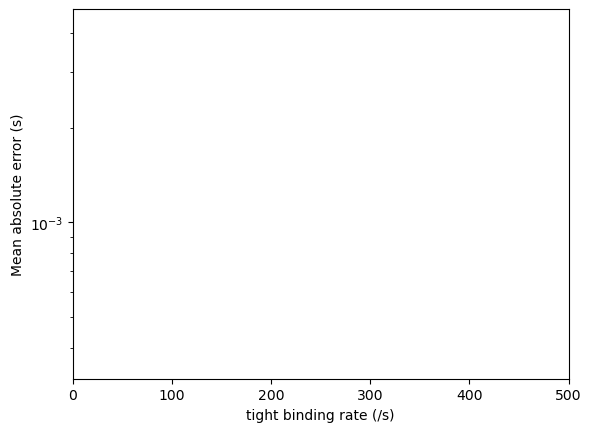

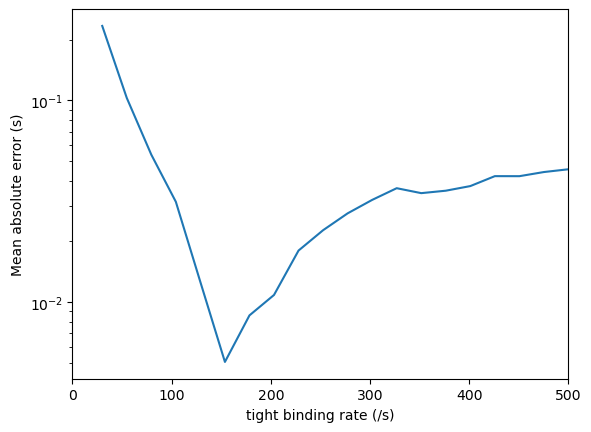

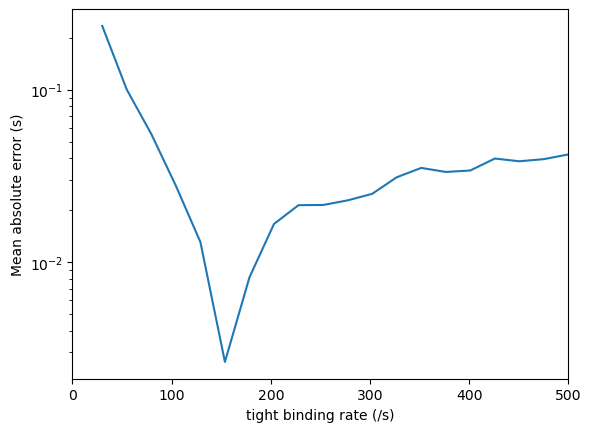

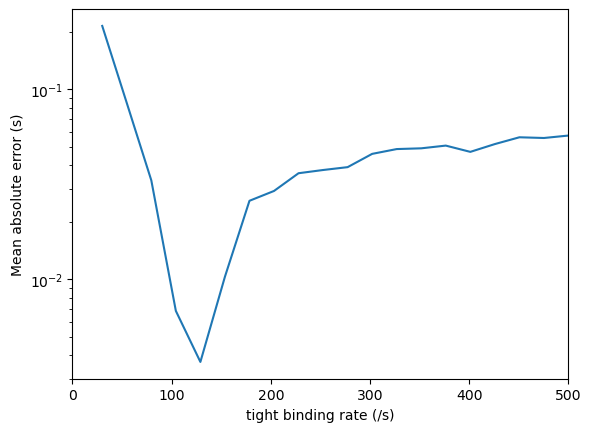

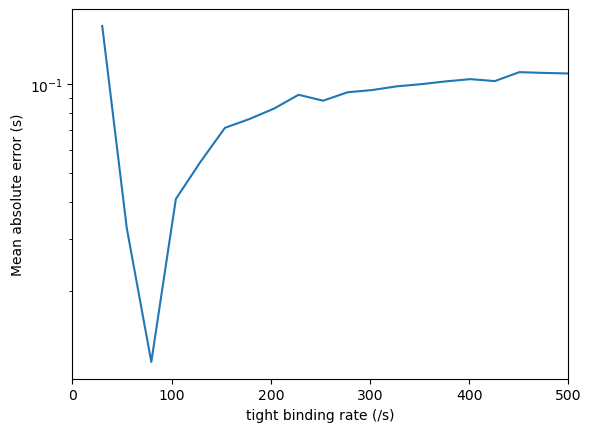

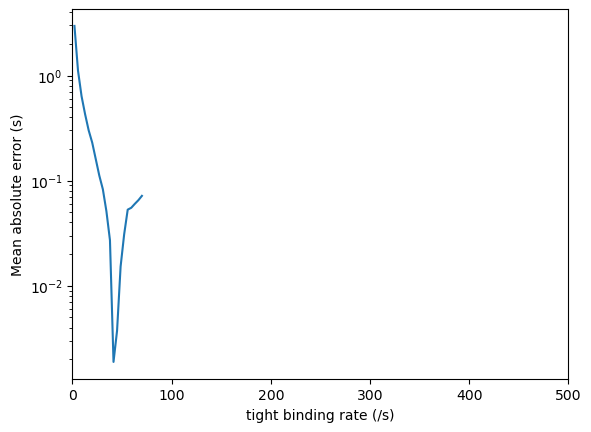

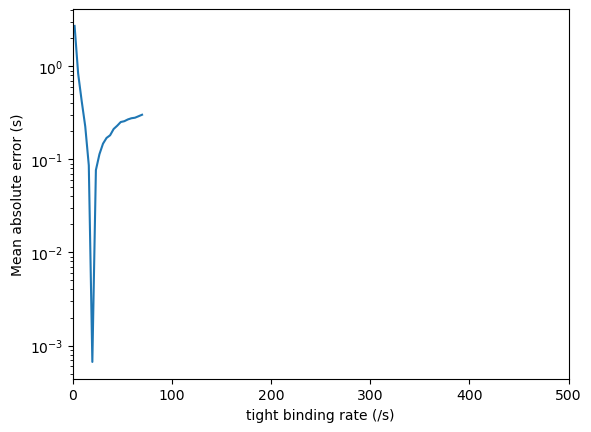

In [6]:
def dwell_error(rates_input, k_tb, dwell_expt_pt):
    rates_input={
                'k_sponthydr': rates_input['k_sponthydr'],
                'k_ATP_unbind': rates_input['k_ATP_unbind'],
                'k_ATP_tightbind': k_tb,
                'k_ATP_bind': 500*rates_input['k_ATP_unbind'],
                'k_ADP_unbind': rates_input['k_ADP_unbind'],
                'k_ATP_bind_sp': 500*rates_input['k_ATP_bind_sp'],
                'k_ADP_unbind_sp': rates_input['k_ADP_unbind_sp'],
                'k_hydr': rates_input['k_hydr'],
            }
    mean_dwell,mean_burst,mean_burstsize, nmin = generate_mean_dwellburst(
            rates_input, 1000, 3)
    error = abs(dwell_expt_pt - np.mean(mean_dwell))
    return error
    
dwell_expt_fillscan = np.array([0.1058,0.1595, 0.1563,  0.1723, 0.2243, 0.3002, 0.5231])
fillscan_expt = np.array([20.0000,54.8387,64.6452,   74.4516,   86.3226,   92.5161,   97.1613])

#Find k_tb values that minimize dwell time error
ktb_min = np.zeros(len(dwell_expt_fillscan))

for i,dwell_expt_pt in enumerate(dwell_expt_fillscan):
    
    #Determine search range
    if fillscan_expt[i] < 30:
        search_range = np.linspace(1000,1400,5) #coarse search for low filling
    elif (fillscan_expt[i] < 90) & (fillscan_expt[i] > 30):
        search_range = np.linspace(30,500,20) #medium search for medium filling
    else:
        search_range = np.linspace(2,70,20) #fine grain search for high filling
    
    #Calculate errors and plot
    errs = [dwell_error(rates, x, dwell_expt_pt) for x in search_range]
    fig,ax = plt.subplots(1,1)
    ax.plot(search_range, errs)
    ax.set_yscale('log')
    ax.set_xlim((0,500))
    ax.set_xlabel('tight binding rate (/s)')
    ax.set_ylabel('Mean absolute error (s)')
    
    #Output k_tb value
    ktb_min[i] = search_range[np.argmin(errs)]
    
#Fit function for converting filling to k_tb - fix this eventually! (curve_fit failure)
def fill2ktb(x): 
    return 3446*np.exp(-0.04815*x)

    

In [7]:
def generate_data(rates, ntrials, min_spont):
    
    ###Experimental data
    ATP_array = 1e3*np.array([0.0097,0.0243,0.0501,0.1000,0.2434,0.4909,1.0200]) #from [1]
    mean_dwells_expt_ATP_scan =  np.array([0.3327, 0.2321, 0.1700, 0.1436, 0.1202, 0.1086, 0.0951])
    mean_dwells_expt_ATP_scan_err = np.array([0.08,0.015,0.001,0.001,0.001,0.001,0.001])
    nmin_expt_ATPscan = np.array([3.6097, 3.9664, 4.3316, 4.8277, 3.803, 3.2220, 3.8051]) 
    nmin_expt_ATPscan_err = np.array([0.4916,    0.2842,    0.3030,    0.3746,    0.2800,    0.2908,    0.4804])
    fillscan_expt = np.array([20.0000,54.8387,64.6452,   74.4516,   86.3226,   92.5161,   97.1613])
    mean_dwells_expt_fillscan = np.array([0.1058,0.1595, 0.1563,  0.1723, 0.2243, 0.3002, 0.5231])
    mean_dwells_expt_fillscan_err=np.array([0.0250,    0.0290,    0.0116,    0.0072,    0.0087,    0.0174,    0.0377])
    vmax_expt_fillscan  = np.array([94.7699,   66.9889,   55.2869,   41.5397,   25.0935,   16.9699,    9.0737])
    vmax_expt_fillscan_err = np.array([4.8505,    3.8230,    3.5679,    3.0648,    3.0612,    3.0612,    2.8097])
    km_expt_fillscan = np.array([17.6071,   14.2857,   12.2500,   10.6786,    8.1786,    7.3571,    6.3571])
    km_expt_fillscan_err = np.array([2.5478,    1.6357,    2.1386,   2.3177,    1.3666,    2.0013,    1.6803])

    

    ##Calculate dwell times and nmin vs [ATP] at low filling
    mean_dwells_ATPscan, nmins_ATPscan = generate_dwell_nmin_vs_ATP(rates, ntrials, min_spont, ATP_array)



    ## Data generation for filling comparison
    ##Calculate dwell times, Vmax, and Km vs filling at high [ATP]

    #Calculate mean dwell for each value
    mean_dwells_fillscan=np.zeros(len(fillscan_expt)) #simulated dwell time array vs filling
    for i in range(len(fillscan_expt)): 
        mean_dwell,mean_burst,mean_burstsize, nmin = generate_mean_dwellburst(
            {
                'k_sponthydr': rates['k_sponthydr'],
                'k_ATP_unbind': rates['k_ATP_unbind'],
                'k_ATP_tightbind': fill2ktb(fillscan_expt[i]),
                'k_ATP_bind': 500*rates['k_ATP_bind'],
                'k_ADP_unbind': rates['k_ADP_unbind'],
                'k_ATP_bind_sp': 500*rates['k_ATP_bind_sp'],
                'k_ADP_unbind_sp': rates['k_ADP_unbind_sp'],
                'k_hydr': rates['k_hydr']

            }, ntrials, min_spont)

        mean_dwells_fillscan[i] = mean_dwell


    #Calculate vmax,km
    #For each filling, calculate vmax and km. 
    fill_plot = np.linspace(20,98,4)
    vmax_fillscan= np.zeros(len(fill_plot))
    km_fillscan = np.zeros(len(fill_plot))
    for i,fill in enumerate(fill_plot):
        rates_new = {
                'k_sponthydr': rates['k_sponthydr'],
                'k_ATP_unbind': rates['k_ATP_unbind'],
                'k_ATP_tightbind': fill2ktb(fill),
                'k_ATP_bind': rates['k_ATP_bind'],
                'k_ADP_unbind': rates['k_ADP_unbind'],
                'k_ATP_bind_sp': rates['k_ATP_bind_sp'],
                'k_ADP_unbind_sp': rates['k_ADP_unbind_sp'],
                'k_hydr': rates['k_hydr']
                }

        vmax,km = generate_vmax_km(rates_new, ntrials, min_spont)
        vmax_fillscan[i] = vmax
        km_fillscan[i]=km

   


    plot_data_dict = {
        'ATP':ATP_array,
        'dwell_ATPscan':mean_dwells_ATPscan,
        'nmin_ATPscan':nmins_ATPscan,
        'dwell_expt_ATP_scan':mean_dwells_expt_ATP_scan,
        'nmin_expt_ATPscan':nmin_expt_ATPscan,
        'dwell_expt_ATP_scan_err':mean_dwells_expt_ATP_scan_err,
        'nmin_expt_ATPscan_err':nmin_expt_ATPscan_err,
        'filling_scan':fill_plot,
        'dwell_fillscan':mean_dwells_fillscan,
        'vmax_fillscan':vmax_fillscan,
        'km_fillscan':km_fillscan,
        'filling_expt':fillscan_expt,
        'dwell_expt_fillscan':mean_dwells_expt_fillscan,
        'dwell_expt_fillscan_err':mean_dwells_expt_fillscan_err,
        'vmax_expt_fillscan':vmax_expt_fillscan,
        'vmax_expt_fillscan_err':vmax_expt_fillscan_err,
        'km_expt_fillscan': km_expt_fillscan,
        'km_expt_fillscan_err': km_expt_fillscan_err
    }
    
    return plot_data_dict

In [8]:
def MakePlots(dinput):

    FS = 18
    lw_sim=2
    fsize = (14,6)
    fig1,(ax1,ax2) = plt.subplots(1,2, figsize=fsize)


    #Dwell vs [ATP] comparison
    ax1.errorbar(dinput['ATP'], dinput['dwell_expt_ATP_scan'],
                 yerr=dinput['dwell_expt_ATP_scan_err'], fmt='.--',
                 markersize=12,markeredgewidth =3, capsize=3,elinewidth=3, color='black', lw=2)
    ax1.plot(dinput['ATP'],dinput['dwell_ATPscan'],color='tab:red', lw=lw_sim ) #add error bars to this eventually
    ax1.set_xlabel('[ATP]',fontdict={'fontsize':FS})
    ax1.set_ylabel('Dwell time (s)',fontdict={'fontsize':FS})
    ax1.tick_params(labelsize=FS)
    ax1.legend(['Simulation', 'Experimental data'],fontsize=FS)



    #Dwell vs filling comparison
    ax2.errorbar(dinput['filling_expt'], dinput['dwell_expt_fillscan'],
                 yerr=dinput['dwell_expt_fillscan_err'], fmt='.--',
                 markersize=15, markeredgewidth =3, capsize=3, elinewidth=3, color='black',
                 markerfacecolor = 'white',lw=2)
    ax2.plot(dinput['filling_expt'], dinput['dwell_fillscan'],color='tab:red', lw=lw_sim ) #add error bars to this eventually
    ax2.set_xlabel('Filling (%)',fontdict={'fontsize':FS})
    ax2.set_ylabel('Dwell time (s), [ATP] = 500 uM',fontdict={'fontsize':FS})
    ax2.tick_params(labelsize=FS)

    fig1,(ax3,ax4) = plt.subplots(1,2, figsize=fsize)

    # #Vmax vs filling comparison
    ax3.errorbar(dinput['filling_expt'], dinput['vmax_expt_fillscan'],
                 yerr=dinput['vmax_expt_fillscan_err'], fmt='^--',
                 markersize=12,markeredgewidth =3, capsize=3,elinewidth=3, color='tab:blue', lw=2)
    ax3.plot(dinput['filling_scan'], dinput['vmax_fillscan'],color='tab:red', lw=lw_sim ) #add error bars to this eventually
    ax3.set_xlabel('Filling (%)',fontdict={'fontsize':FS})
    ax3.set_ylabel(' Vmax (bp/s) ',fontdict={'fontsize':FS})
    ax3.tick_params(labelsize=FS)

    # #Km vs filling comparison
    ax4.errorbar(dinput['filling_expt'], dinput['km_expt_fillscan'],
                 yerr=dinput['km_expt_fillscan_err'], fmt='^--',
                 markersize=12,markeredgewidth =3, capsize=3,elinewidth=3, color='tab:green', lw=2)
    ax4.plot(dinput['filling_scan'], dinput['km_fillscan'],color='tab:red', lw=lw_sim ) #add error bars to this eventually
    ax4.set_xlabel('Filling (%)',fontdict={'fontsize':FS})
    ax4.set_ylabel('Km (uM)',fontdict={'fontsize':FS})
    ax4.tick_params(labelsize=FS)


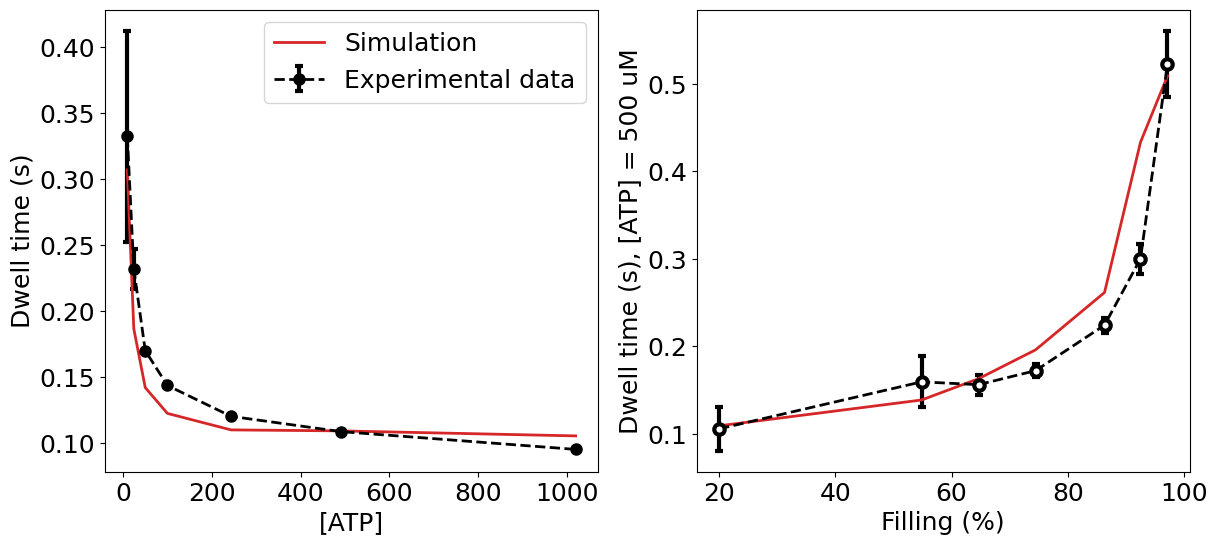

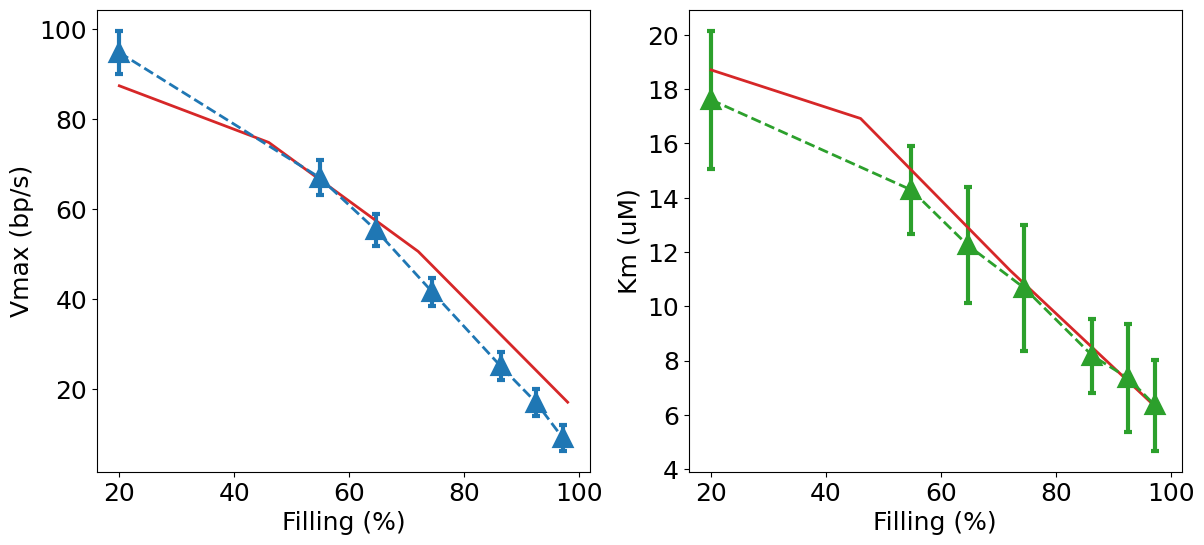

In [10]:
#Rates dict is defined above
ntrials = 1000 #number of trials per simulation
min_spont=3    #minimum number of subunits req. for spontaneous hydrolysis

data_dict = generate_data(rates, ntrials, min_spont)
MakePlots(data_dict)

Text(82, 45, 'Increasing \n    [ATP]')

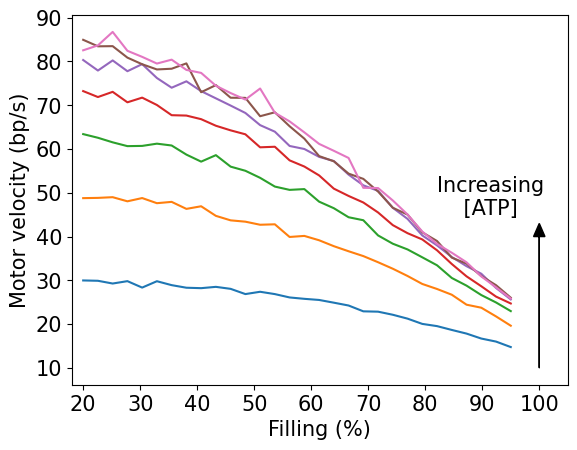

In [70]:
#Simulate motor velocity vs filling for different [ATP]
ntrials=1000
min_spont=3
highfilling_dwells = []

ATP_array = 1e3*np.array([0.0097,0.0243,0.0501,0.1000,0.2434,0.4909,1.0200]) #ATP concentrations
filling = np.linspace(20,95,30)
vels = np.zeros((len(filling),len(ATP_array)))


for i,ATP in enumerate(ATP_array):
    for j,fill in enumerate(filling):
#         print(ATP)
#         print(fill)
    
        rate_trial = {  
                    'k_sponthydr': rates['k_sponthydr'],
                    'k_ATP_unbind': rates['k_ATP_unbind'],
                    'k_ATP_tightbind': fill2ktb(fill),
                    'k_ATP_bind': ATP*rates['k_ATP_bind'],
                    'k_ADP_unbind': rates['k_ADP_unbind'],
                    'k_ATP_bind_sp': ATP*rates['k_ATP_bind_sp'],
                    'k_ADP_unbind_sp': rates['k_ADP_unbind_sp'],
                    'k_hydr': rates['k_hydr']}
        vels[j,i], nmin, d, b, bs = generate_packaging(rate_trial,
                                                 ntrials, min_spont, return_dist=True)
        if fill==90:
            highfilling_dwells.append(d)
        
        
# Plot
for k in range(7):
    plt.plot(filling,vels[:,k])
FS = 15

plt.xlabel('Filling (%)', fontsize=FS)
plt.ylabel('Motor velocity (bp/s)', fontsize=FS)
plt.xticks(fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlim((18,105))
plt.arrow(100, 10, 0, 30,head_width=2,facecolor='black')
plt.text(82,45,'Increasing \n    [ATP]',fontdict={'fontsize':FS})